In [ ]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
import torch
import pandas as pd
import re
import gc
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

from model_evaluation.test_MLLMs import run_vlm_evaluation
from making_color_images.model_priors import TorchColorPriors, GPTColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid, plot_vlm_performance, variant_label
from making_color_images.recolor_images import generate_variants, resize_all_images_and_masks


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

## Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

model_name = "llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1. Simple Fruit Dataset

In [5]:
# Simple fruit dataset
evaluate_fruit = False
df = pd.read_parquet(FRUIT/ "fruit_images.parquet")

if evaluate_fruit:
    df_results = run_vlm_evaluation(
        df,
        processor,
        model,
        device,
        mode="both"
    )
    
    display(df_results)
    out_path = FRUIT / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (FRUIT / "outline_results.csv").exists():
    fruit_df = pd.read_csv(FRUIT / "results_llava-next_both.csv")
    display(fruit_df)

,object,image_type,image_path,pred_color_most,pred_color_this
0,banana,grayscale,data/fruit/banana1.jpeg,yellow,yellow
1,banana,background,data/fruit/banana1_background.jpeg,yellow,white
2,banana,color,data/fruit/banana1_color.jpeg,yellow,yellow
3,banana,grayscale,data/fruit/banana2.jpeg,yellow,black
4,banana,background,data/fruit/banana2_background.jpeg,yellow,white
5,banana,color,data/fruit/banana2_color.jpeg,yellow,yellow
6,blueberry,grayscale,data/fruit/blueberry.jpeg,white,white
7,blueberry,background,data/fruit/blueberry_background.jpeg,white,white
8,blueberry,color,data/fruit/blueberry_color.jpeg,blue,blue
9,cucumber,grayscale,data/fruit/cucumber.jpeg,green,white


## 2. Outline Image Dataset 

## 2.1. Query world-knowledge color priors

In [4]:
# Load dataframe with outline images and masks
df = pd.read_csv(DATA / "segmented_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [ ]:
from PIL import Image

# Loop through the DataFrame and display each image
for i, row in df[120:160].iterrows():
    if row["image_path"]:  # Check if there is an image path
            image_path = f"{row['image_path']}"
            print(f"Displaying: {image_path}")  # Print file name

            # Open and display the image
            try:
                image = Image.open(image_path)
                plt.figure()  # Create a new figure for each image
                plt.imshow(image)
                plt.axis("off")  # Hide axes
                #plt.title(f"{row['correct_answer']} {row['correct_object']} - Image {j+1}")  # Title with object, color, and number
                plt.show()  # Show the image
            except Exception as e:
                print(f"Error displaying {image_path}: {e}")

In [5]:
# Initalize ModelColorPriors
priors = TorchColorPriors(
    processor=processor,
    model=model,
    data_folder=DATA,
    device=device
)

In [26]:
# Generate new priors
# priors_df = priors.get_model_color_priors(df, save=True)

In [6]:
# Checkpoint: display the generated priors
priors_df = priors.load_model_priors()
display(priors_df[['object', 'correct_answer', 'dummy_priors', 'image_priors']])

,object,correct_answer,dummy_priors,image_priors
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, black, white]"
1,tabby,"[brown, black, orange]","[black, grey, white]","[black, grey, white]"
2,spoonbill,"[pink, white]","[pink, white, black]","[white, black, grey]"
3,Samoyed,[white],"[white, cream, light brown]","[white, cream, light grey]"
4,Norwegian elkhound,"[grey, black]","[grey, black, brown]","[white, grey, black]"
...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, white]","[gold, silver, black]"
216,pill bottle,"[orange, white]","[blue, white, green]","[white, blue, green]"
217,dial telephone,[black],"[black, white, grey]","[black, white, grey]"
218,digital watch,[black],"[black, grey, blue]","[black, silver, white]"


In [7]:
# Pick a primary color prior, overwrite correct_answer, and drop all rows where the prior is None
DUMMY = False  # Set to True to use dummy priors, False for image priors
suffix = "dummy_priors" if DUMMY else "image_priors"
priors_df["prior"], priors_df["prior_changed"] = priors.pick_primary_color(priors_df, column=suffix)

[INFO] tabby: replaced 'black' with 'grey'
[INFO] spoonbill: replaced 'white' with 'grey'
[NULL] Samoyed: all priors invalid ['white', 'cream', 'light grey'] to NaN
[INFO] Norwegian elkhound: replaced 'white' with 'grey'
[INFO] hare: replaced 'white' with 'grey'
[NULL] car wheel: all priors invalid ['black', 'silver', 'white'] to NaN
[INFO] dandelion: replaced 'white' with 'yellow'
[INFO] bat_(animal): replaced 'black' with 'grey'
[INFO] buffalo: replaced 'black' with 'grey'
[INFO] ground beetle: replaced 'black' with 'brown'
[INFO] miniature pinscher: replaced 'white' with 'brown'
[INFO] oriole: replaced 'black' with 'grey'
[INFO] wombat: replaced 'black' with 'grey'
[INFO] tiger: replaced 'black' with 'orange'
[INFO] Chesapeake Bay retriever: replaced 'black' with 'brown'
[INFO] gorilla: replaced 'black' with 'brown'
[INFO] golf ball: replaced 'white' with 'yellow'
[INFO] spotted salamander: replaced 'black' with 'brown'
[INFO] american football: replaced 'white' with 'brown'
[NULL] 

In [29]:
print(f"Number of objects with valid model color priors: {len(priors_df['prior'].dropna())}")
print(f"Number of objects where the original prior was changed to be valid: {priors_df['prior_changed'].sum()}")
df["correct_answer"] = priors_df["prior"]

df.dropna(subset=["correct_answer"], axis=0, inplace=True)

#priors.analyze_differences(priors_df)
display(df)
df["correct_answer"].value_counts()

Number of objects with valid model color priors: 195
Number of objects where the original prior was changed to be valid: 117


,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,yellow,purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,grey,green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,pink,green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,grey,red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
5,red,yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
214,red,blue,apple,https://i.pinimg.com/736x/48/39/63/48396351091...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,blue,purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,grey,pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,grey,pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


correct_answer
grey      48
brown     47
red       38
green     23
yellow    13
blue      12
orange    10
pink       2
purple     2
Name: count, dtype: int64

## 2.2. Resize images and masks

In [8]:
df = resize_all_images_and_masks(
    df,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)


Resizing all: 100%|██████████| 220/220 [00:13<00:00, 16.21it/s]

Resized 220 images.


## 2.3. Recolor outline images with model prior

In [9]:
# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 60, 10)) + list([55]) + list(range(60, 110, 10))
print(pct_schedule)

# Set coloring modes
coloring_modes = ["sequential"] #, "independent"]

OUT_COLOR = OUTLINES / model_name / suffix
OUT_COLOR.mkdir(parents=True, exist_ok=True)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 55, 60, 70, 80, 90, 100]


In [35]:
# Generate variants for all images in df
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            step_size=10,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


In [11]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

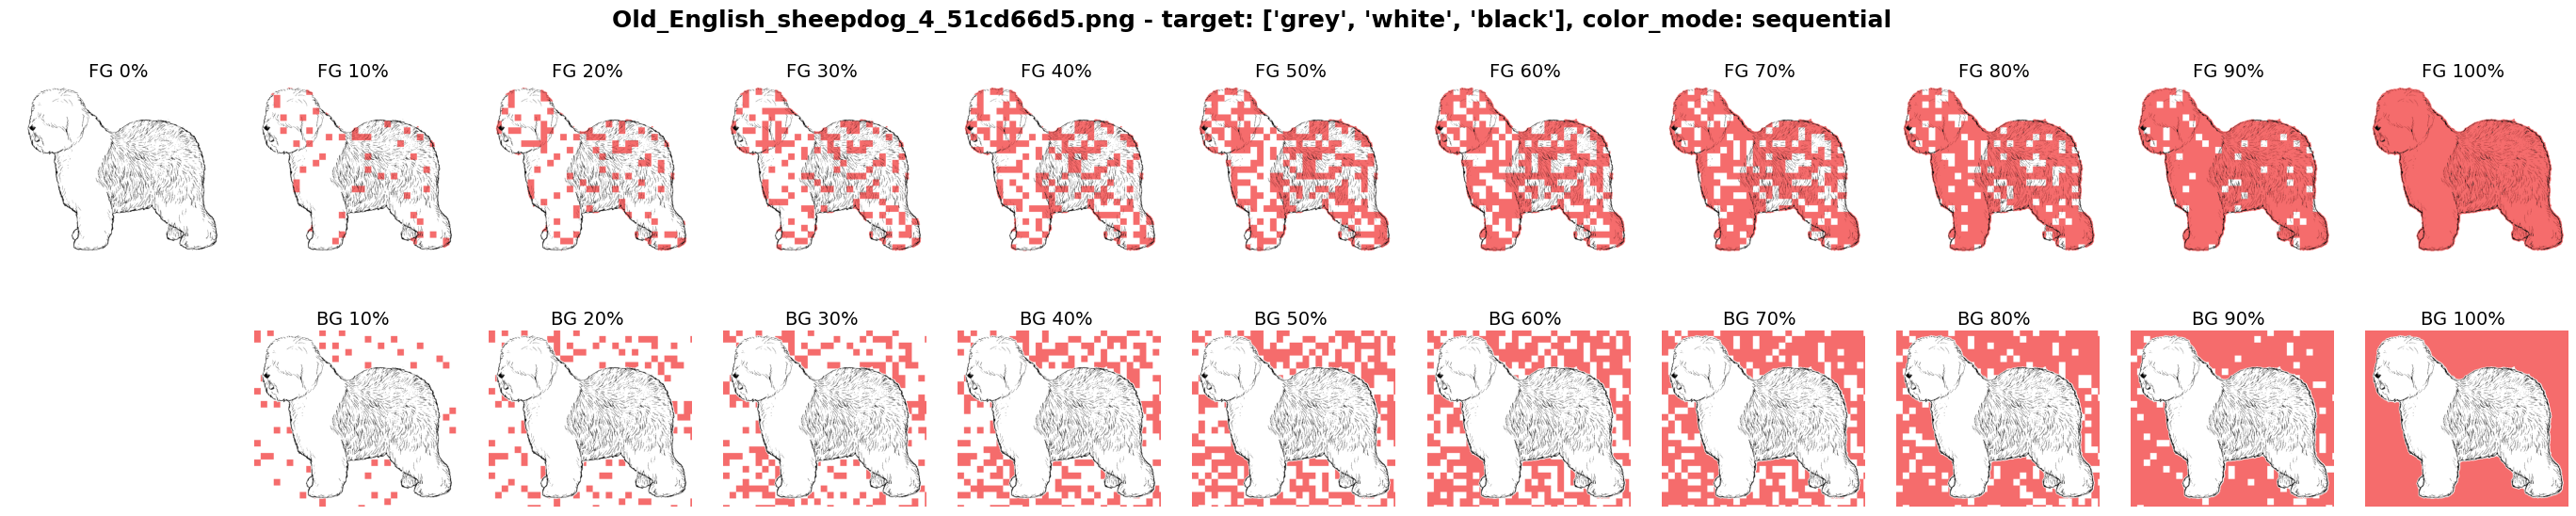

In [36]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['correct_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

## 2.4. Evaluate open-weight models on recolored image variants

In [ ]:
# Main evaluation of color outline variants only for sequential coloring and 'this' prompt
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects", position=0):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["correct_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=OUT_COLOR)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="this",
        return_probs=True   
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this", "prob_correct_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation...


Evaluating objects: 100%|██████████| 215/215 [4:31:08<00:00, 75.67s/it]  


NameError: name 'data_folder' is not defined

In [22]:
# Checkpoint: Load evaluation
# Results for model prior with black-white image given
pred_color_df = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
display(pred_color_df)

# Results for dummy model prior
pred_color_df_dummy = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_dummy_priors.csv")
display(pred_color_df_dummy)

,object,image_variant,correct_answer,pred_color_this,prob_correct_this
0,sunflower,BG 0% (seq),yellow,white,0.001710
1,sunflower,BG 1% (seq),yellow,white,0.042755
2,sunflower,BG 2% (seq),yellow,white,0.042511
3,sunflower,BG 3% (seq),yellow,white,0.043091
4,sunflower,BG 4% (seq),yellow,white,0.042267
...,...,...,...,...,...
4435,digital watch,FG 60% (seq),black,black,0.863281
4436,digital watch,FG 70% (seq),black,black,0.888184
4437,digital watch,FG 80% (seq),black,black,0.912598
4438,digital watch,FG 90% (seq),black,black,0.922852


,object,image_variant,correct_answer,pred_color_this,prob_correct_this
0,sunflower,BG 0% (seq),yellow,white,0.000854
1,sunflower,BG 1% (seq),yellow,white,0.160889
2,sunflower,BG 2% (seq),yellow,white,0.195923
3,sunflower,BG 3% (seq),yellow,white,0.237061
4,sunflower,BG 4% (seq),yellow,white,0.228394
...,...,...,...,...,...
8595,tow truck,FG 60% (seq),red,red,0.897461
8596,tow truck,FG 70% (seq),red,red,0.906250
8597,tow truck,FG 80% (seq),red,red,0.922852
8598,tow truck,FG 90% (seq),red,red,0.939941


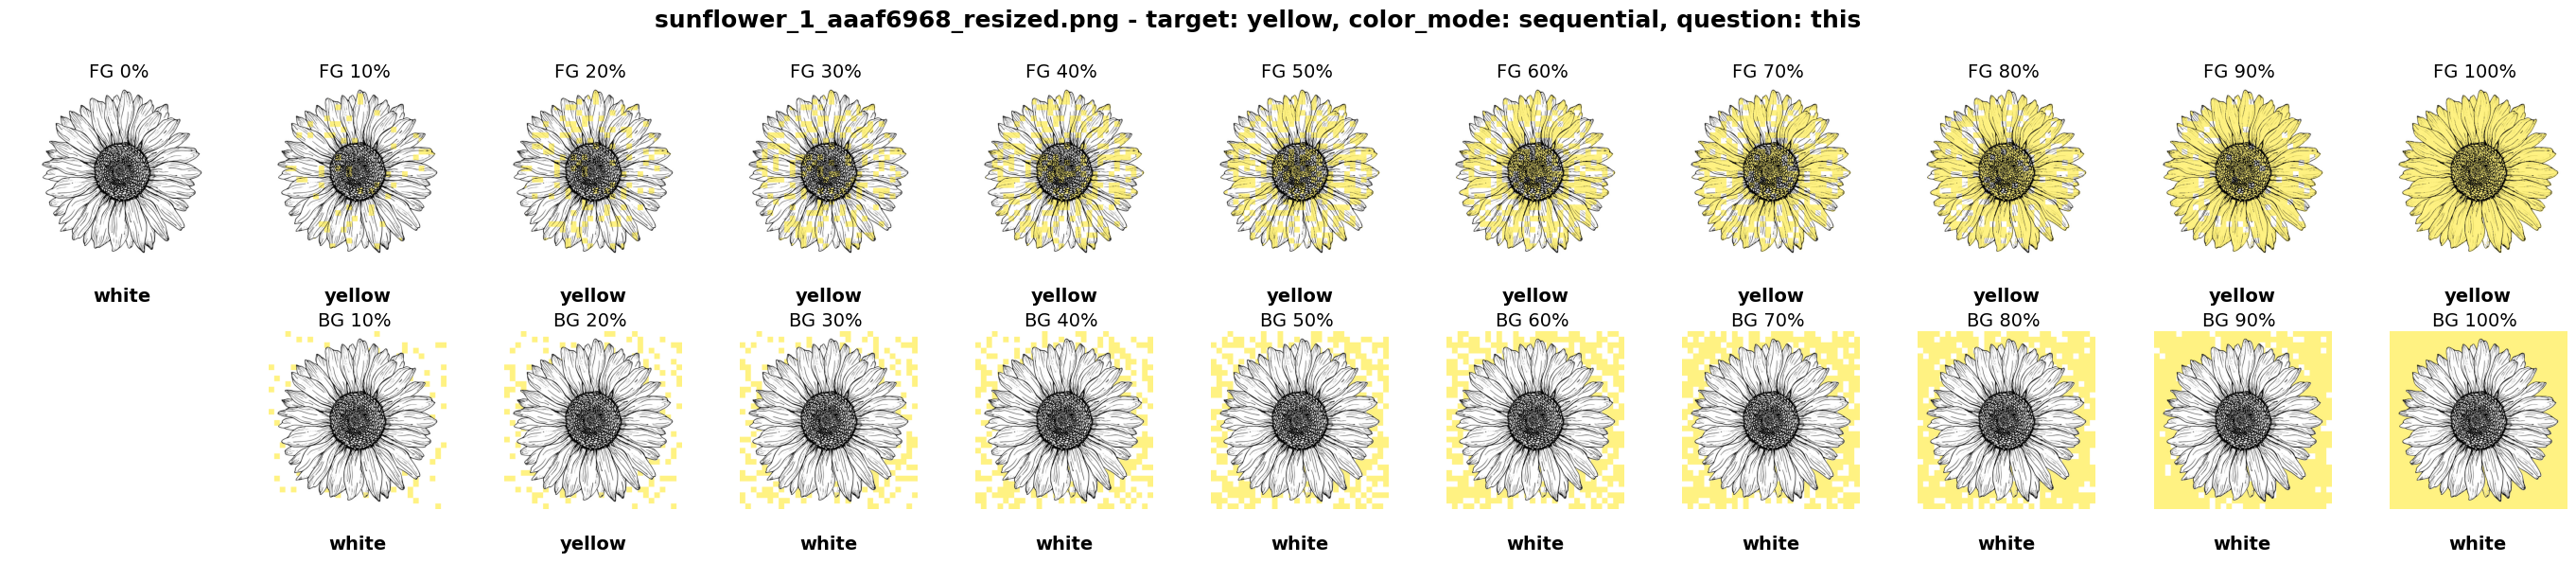

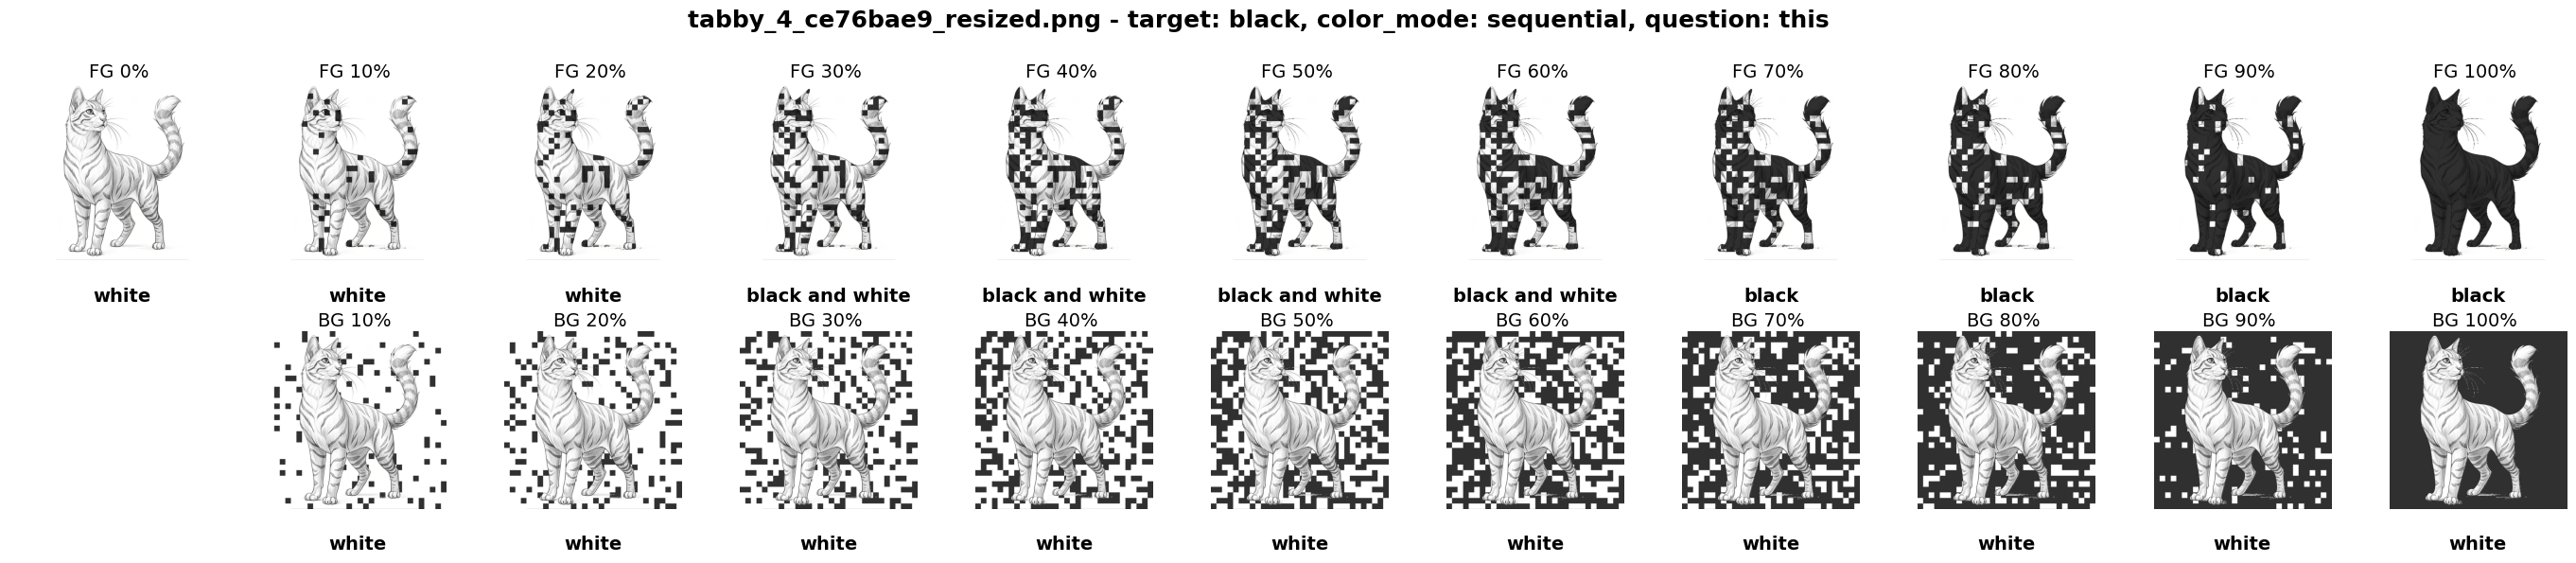

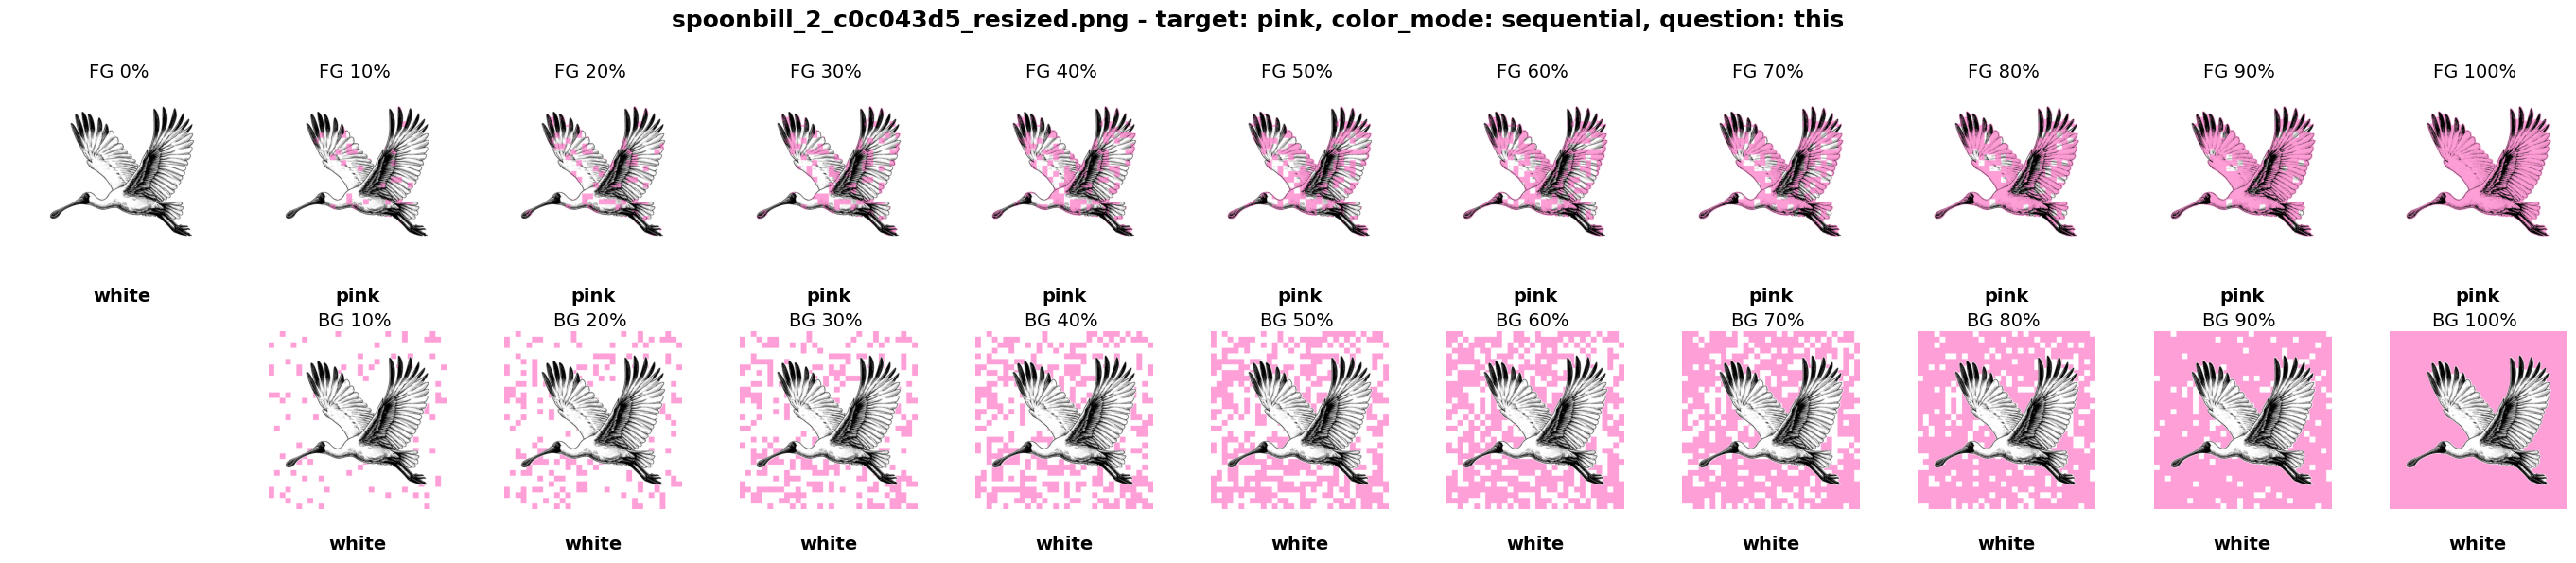

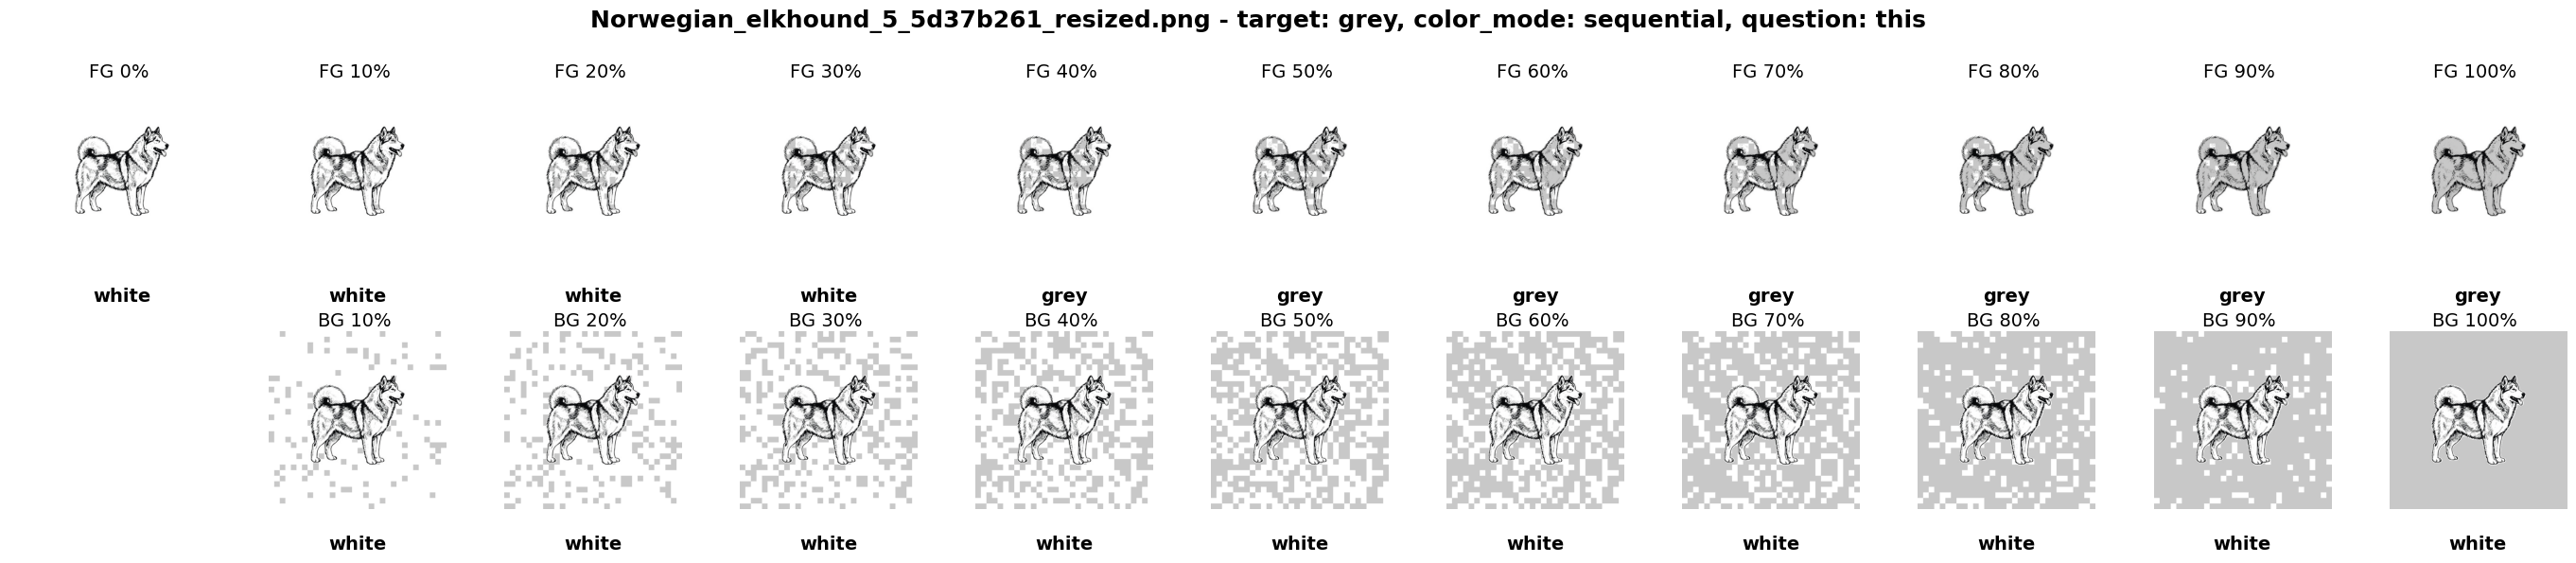

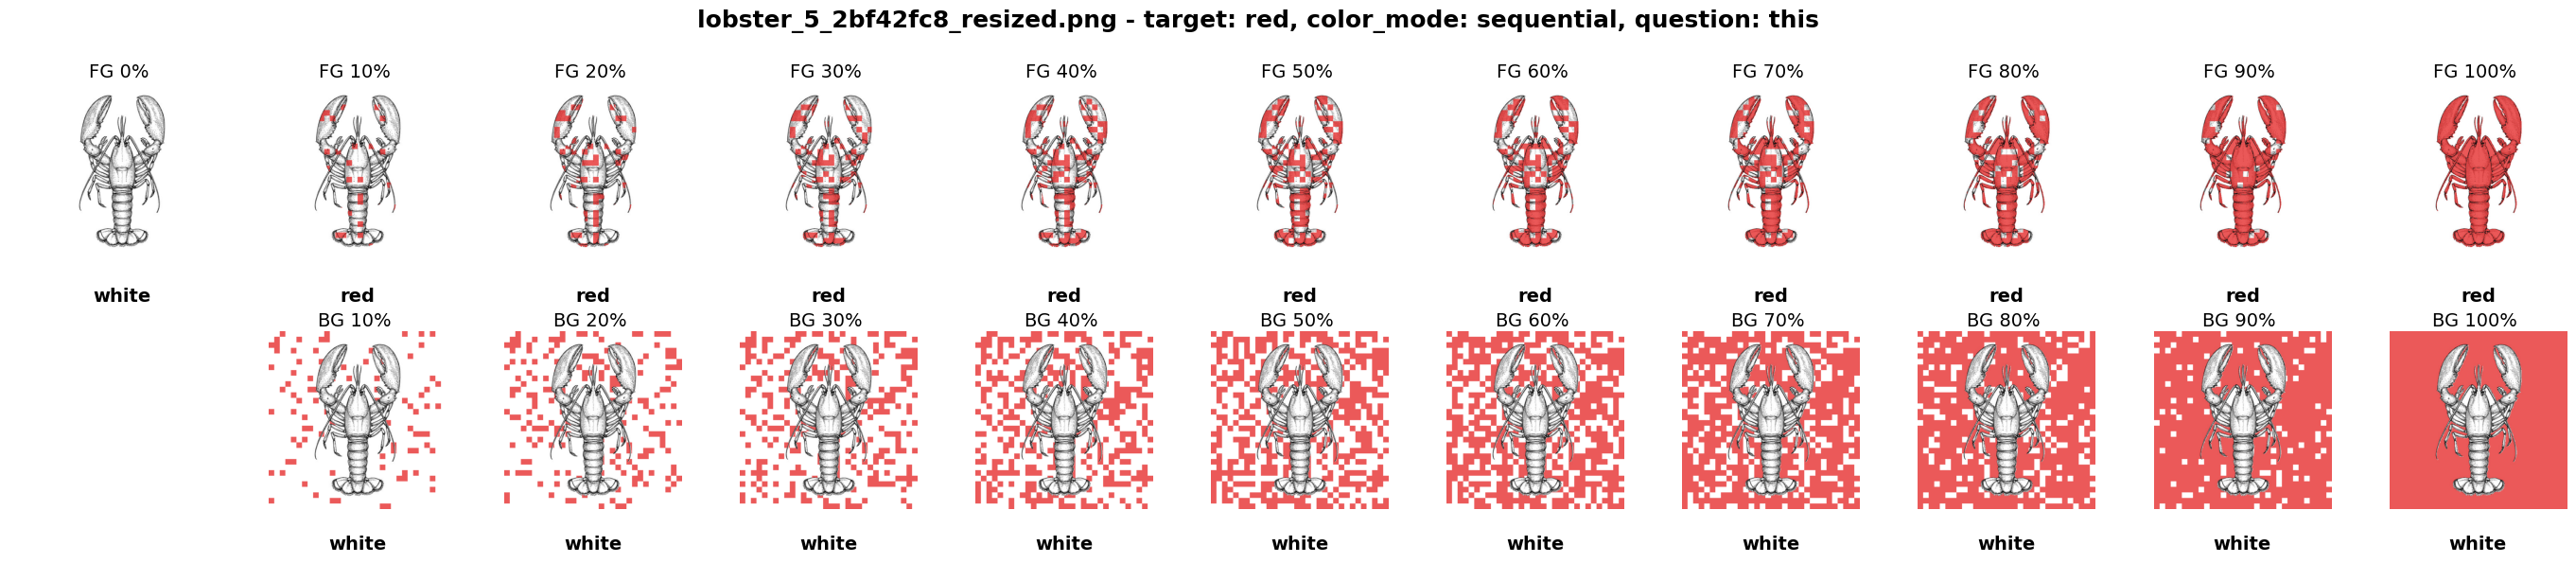

In [23]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row["image_path"], row['correct_answer'], OUT_COLOR, pred_color_df_dummy, question="this", color_mode="sequential", pct_range=ten_increase)
        #show_variants_grid(row["image_path"], row['correct_answer'], color_outlines, pred_color_df, question="most", color_mode=color_mode, pct_range=compact)
    

In [9]:
modes = ["seq"] #"ind"]

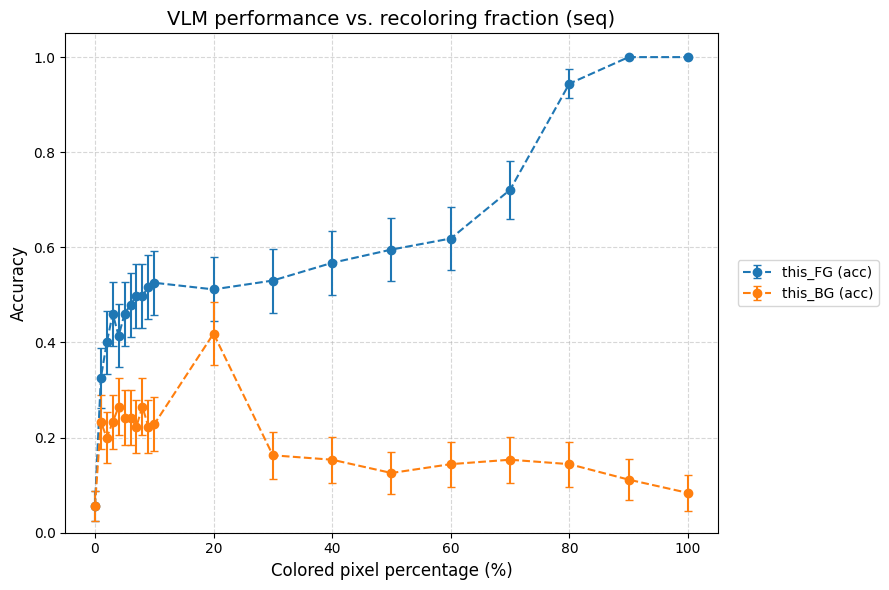

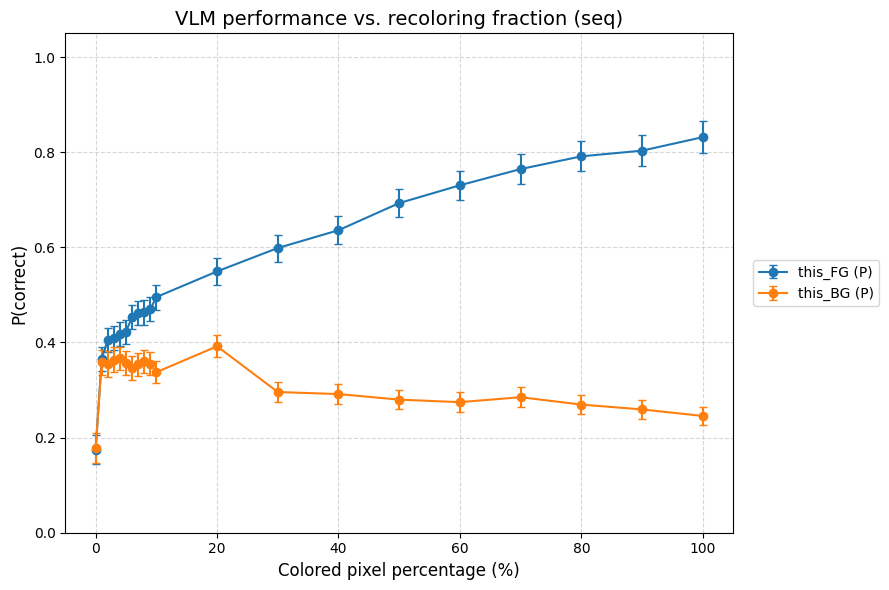

In [26]:
# Plot full range
for mode in modes:
    plot_vlm_performance(pred_color_df_dummy, show_accuracy=True, ci=True, show_probability=False, color_mode=mode)
    plot_vlm_performance(pred_color_df_dummy, show_accuracy=False, ci=True, show_probability=True, color_mode=mode)

## 2.5. Color and evaluate VLM with counterfact color

In [10]:
# Counterfact colors in df
df["incorrect_answer"].unique().tolist()

['purple', 'green', 'red', 'yellow', 'brown', 'pink', 'blue', 'orange']

In [13]:
missing_objects = ['Rottweiler', 'Sealyham terrier', 'curly-coated retriever', 'dalmatian', 'espresso maker', 'flat-coated retriever', 'flute', 'radio', 'screw', 'strainer', 'typewriter', 'van', 'waffle iron']
df = df[df["object"].isin(missing_objects)]
model_name = "gpt-4o"

In [16]:
suffix = "counterfact"
OUT_COLOR = OUTLINES / model_name / suffix
OUT_COLOR.mkdir(parents=True, exist_ok=True) 
print(OUT_COLOR)  

for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['incorrect_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/gpt-4o/counterfact


Generating color variants: 100%|██████████| 13/13 [01:38<00:00,  7.58s/it]


In [55]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['incorrect_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/resized_images/Old_English_sheepdog_4_51cd66d5_resized.png


In [ ]:
# Main evaluation of counterfact color outline variants only for sequential coloring and 'this' prompt
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects", position=0):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["incorrect_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=OUT_COLOR)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="this",
        return_probs=True   
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this", "prob_correct_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation...


Evaluating objects: 100%|██████████| 215/215 [4:56:38<00:00, 82.78s/it]  

Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv


,object,image_variant,correct_answer,pred_color_this,prob_correct_this
0,sunflower,BG 0% (seq),purple,white,0.000050
1,sunflower,BG 1% (seq),purple,white,0.094543
2,sunflower,BG 2% (seq),purple,white,0.153931
3,sunflower,BG 3% (seq),purple,white,0.187256
4,sunflower,BG 4% (seq),purple,white,0.200562
5,sunflower,BG 5% (seq),purple,white,0.190796
6,sunflower,BG 6% (seq),purple,white,0.198364
7,sunflower,BG 7% (seq),purple,white,0.194824
8,sunflower,BG 8% (seq),purple,white,0.218750
9,sunflower,BG 9% (seq),purple,white,0.196411


In [ ]:
# Add incorrect_answer column to the results dataframe
llava_counterfact = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")
llava_counterfact = llava_counterfact.merge(
    df[["object", "incorrect_answer"]],
    on="object",
    how="left"
)
llava_counterfact.to_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv", index=False)

8600
0


## 3. Evaluate GPT on recolored image variants

In [42]:
# Load segmented images dataframe again for GPT
df_GPT = pd.read_csv(DATA / "segmented_images.csv")
display(df_GPT)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [43]:
# Initialize GPTColorPriors
model_name = "gpt-4o"
priors_GPT = GPTColorPriors(model_name=model_name, data_folder=DATA)

# Generate GPT color priors
#priors_df_GPT = priors_GPT.get_model_color_priors(df_GPT, save=True)

# Load previously generated GPT priors
priors_df_GPT = priors_GPT.load_model_priors()

display(priors_df_GPT)

,object,correct_answer,dummy_priors,image_priors
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, brown, green]"
1,tabby,"[brown, black, orange]","[brown, grey, orange]","[orange, grey, brown]"
2,spoonbill,"[pink, white]","[white, pink, black]","[white, black, grey]"
3,Samoyed,[white],"[white, cream, biscuit]","[white, cream, light grey]"
4,Norwegian elkhound,"[grey, black]","[grey, black, white]","[white, grey, black]"
...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, bronze]","[gold, silver, bronze]"
216,pill bottle,"[orange, white]","[orange, white, brown]","[brown, white, orange]"
217,dial telephone,[black],"[black, beige, red]","[black, red, beige]"
218,digital watch,[black],"[black, silver, blue]","[silver, black, blue]"


In [44]:
# Create a color prior table with one primary color per object using the IMAGE prompts
DUMMY = False
suffix = "dummy_priors" if DUMMY else "image_priors"
priors_df_GPT["prior"], priors_df_GPT["prior_changed"] = priors_GPT.pick_primary_color(priors_df_GPT, column=suffix)

[INFO] spoonbill: replaced 'white' with 'grey'
[NULL] Samoyed: all priors invalid ['white', 'cream', 'light grey'] to NaN
[INFO] Norwegian elkhound: replaced 'white' with 'grey'
[INFO] hare: replaced 'white' with 'grey'
[INFO] car wheel: replaced 'silver' with 'grey'
[INFO] dandelion: replaced 'white' with 'green'
[INFO] bat_(animal): replaced 'black' with 'brown'
[INFO] ground beetle: replaced 'black' with 'brown'
[NULL] miniature pinscher: all priors invalid ['tan', 'black', 'white'] to NaN
[INFO] Chesapeake Bay retriever: replaced 'black' with 'brown'
[INFO] gorilla: replaced 'black' with 'grey'
[INFO] giraffe: replaced 'tan' with 'brown'
[INFO] golf ball: replaced 'white' with 'yellow'
[NULL] French horn: all priors invalid ['gold', 'silver', 'brass'] to NaN
[NULL] washer: all priors invalid ['white', 'silver', 'black'] to NaN
[NULL] thimble: all priors invalid ['silver', 'gold', 'bronze'] to NaN
[NULL] bathtub: all priors invalid ['white', 'cream', 'light blue'] to NaN
[INFO] scre

In [46]:
print(f"Number of objects with valid model color priors: {len(priors_df_GPT['prior'].dropna())}")
print(f"Number of objects where the original prior was changed to be valid: {priors_df_GPT['prior_changed'].sum()}")
df_GPT["correct_answer"] = priors_df_GPT["prior"]

df_GPT.dropna(subset=["correct_answer"], axis=0, inplace=True)

#priors.analyze_differences(priors_df)
display(priors_df_GPT.dropna())
df_GPT["correct_answer"].value_counts()

Number of objects with valid model color priors: 199
Number of objects where the original prior was changed to be valid: 83


,object,correct_answer,dummy_priors,image_priors,prior,prior_changed
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, brown, green]",yellow,False
1,tabby,"[brown, black, orange]","[brown, grey, orange]","[orange, grey, brown]",orange,False
2,spoonbill,"[pink, white]","[white, pink, black]","[white, black, grey]",grey,True
4,Norwegian elkhound,"[grey, black]","[grey, black, white]","[white, grey, black]",grey,True
5,lobster,[red],"[red, blue, yellow]","[red, brown, blue]",red,False
...,...,...,...,...,...,...
214,apple,"[red, green, yellow]","[red, green, yellow]","[red, green, yellow]",red,False
216,pill bottle,"[orange, white]","[orange, white, brown]","[brown, white, orange]",brown,False
217,dial telephone,[black],"[black, beige, red]","[black, red, beige]",red,True
218,digital watch,[black],"[black, silver, blue]","[silver, black, blue]",blue,True


correct_answer
brown     71
green     28
grey      28
red       27
blue      14
orange    13
yellow    11
pink       4
purple     3
Name: count, dtype: int64

In [47]:
# save filtered dataframe with GPT priors
name = f"color_priors_gpt-4o_{suffix}"
priors_df_GPT.to_csv(DATA / f"{name}.csv", index=False)

In [11]:
# Compare GPT vs Torch priors
torch_df = priors_df[["object", "prior"]].dropna().rename(columns={"prior": "prior_torch"})
gpt_df = priors_df_GPT[["object", "prior"]].dropna().rename(columns={"prior": "prior_gpt"})
valid_torch = torch_df.shape[0]
valid_gpt   = gpt_df.shape[0]
print(f"Number of objects with valid Torch priors: {valid_torch}")
print(f"Number of objects with valid GPT priors: {valid_gpt}")

merged = torch_df.merge(gpt_df, on="object", how="outer")



both_valid = merged.dropna(subset=["prior_torch", "prior_gpt"])
agreement_rate = (both_valid["prior_torch"] == both_valid["prior_gpt"]).mean()

print(f"Agreement rate (only objects with two priors): {agreement_rate:.3f}")
print(f"Compared objects: {len(both_valid)}")

diff = both_valid[both_valid["prior_torch"] != both_valid["prior_gpt"]]
print("Number of disagreements:", len(diff))
display(diff)

NameError: name 'priors_df' is not defined

In [48]:
# Upadate df_GPT with resized images and masks
df_GPT = resize_all_images_and_masks(
    df_GPT,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)

Resizing all: 100%|██████████| 199/199 [00:11<00:00, 17.84it/s]

Resized 199 images.


In [59]:
# Generate variants for all images in GPT prior df
OUT_COLOR = OUTLINES / model_name / suffix
print(f"Saving to {OUT_COLOR}")
OUT_COLOR.mkdir(parents=True, exist_ok=True)  

# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 60, 10)) + list([55]) + list(range(60, 110, 10))
print(pct_schedule)

Saving to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/gpt-4o/image_priors
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 55, 60, 70, 80, 90, 100]


In [61]:
for _, row in tqdm(df_GPT.iterrows(), total=len(df_GPT), desc="Generating color variants"):
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            mode="sequential",
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


In [62]:
for idx, row in df_GPT.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['incorrect_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

No variants found for /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/resized_images/Old_English_sheepdog_4_51cd66d5_resized.png


In [83]:
# Main evaluation of GPT color outline variants only for sequential coloring and 'this' prompt
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df_GPT.iterrows(), total=len(df_GPT), desc="Evaluating objects", position=0):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["correct_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=OUT_COLOR)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="this",
        use_gpt=True
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation...


Evaluating objects:   0%|          | 0/213 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [65]:
suffix = "counterfact"
OUT_COLOR = OUTLINES / model_name / suffix
print(OUT_COLOR)

/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/gpt-4o/counterfact


In [ ]:
# Main evaluation of GPT color outline variants only for sequential coloring and 'this' prompt
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df_GPT.iterrows(), total=len(df_GPT), desc="Evaluating objects", position=0):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["incorrect_answer"]
    
    # Collect all variant image paths for this color
    variant_root = Path(str(OUT_COLOR).replace("gpt-4o", "llava-v1.6-mistral-7b-hf"))
    variants = collect_variants_for(image_path, target_color, out_root=variant_root)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="this",
        use_gpt=True
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation...


Evaluating objects: 100%|██████████| 2/2 [02:16<00:00, 68.36s/it]

Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/evaluation_gpt-4o_counterfact.csv


,object,image_variant,correct_answer,pred_color_this
0,sunflower,BG 0% (seq),purple,black-and-white
1,sunflower,BG 1% (seq),purple,black
2,sunflower,BG 2% (seq),purple,black-and-white
3,sunflower,BG 3% (seq),purple,black
4,sunflower,BG 4% (seq),purple,black-and-white
5,sunflower,BG 5% (seq),purple,black-and-white
6,sunflower,BG 6% (seq),purple,black-and-white
7,sunflower,BG 7% (seq),purple,black-and-white
8,sunflower,BG 8% (seq),purple,black-and-white
9,sunflower,BG 9% (seq),purple,black-and-white


In [ ]:
# Add incorrect_answer column to the results dataframe
gpt4o_counterfact = pd.read_csv(DATA / "evaluation_gpt-4o_counterfact.csv")
gpt4o_counterfact = gpt4o_counterfact.merge(
    df[["object", "incorrect_answer"]],
    on="object",
    how="left"
)
gpt4o_counterfact.to_csv(DATA / "evaluation_gpt-4o_counterfact.csv", index=False)

8600
0


In [30]:
gpt_dummy = pd.read_csv(DATA / "evaluation_gpt-4o_dummy_priors.csv")
gpt_counterfact = pd.read_csv(DATA / "evaluation_gpt-4o_counterfact.csv")
llava_dummy = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_dummy_priors.csv")
llava_image = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_image_priors.csv")
llava_counterfact = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_counterfact.csv")


In [14]:
print(gpt_dummy.shape)
print(gpt_counterfact.shape)
print(llava_dummy.shape)
print(llava_image.shape)
print(llava_counterfact.shape)

(8520, 4)
(8600, 5)
(8600, 5)
(4440, 5)
(8600, 5)


LLaVA-NeXT performance (color prior without image):


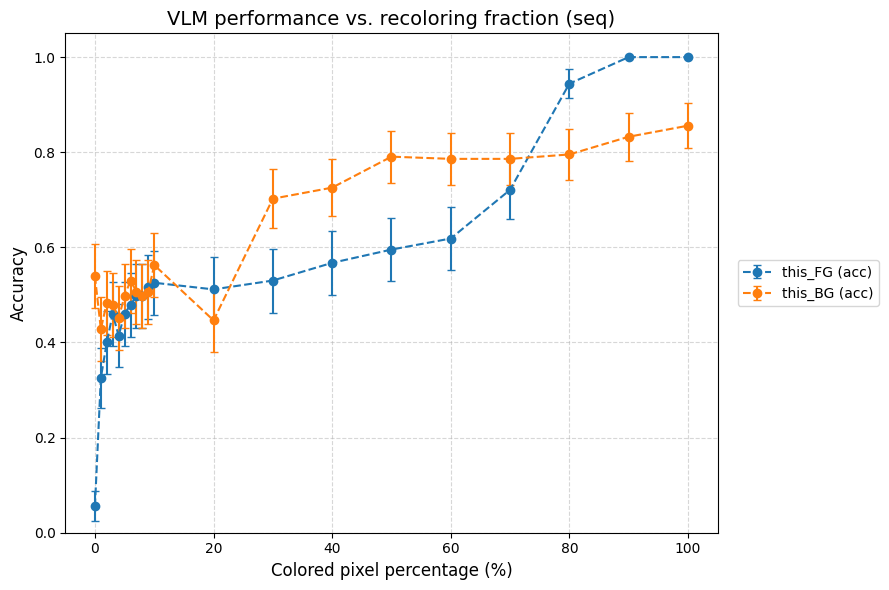

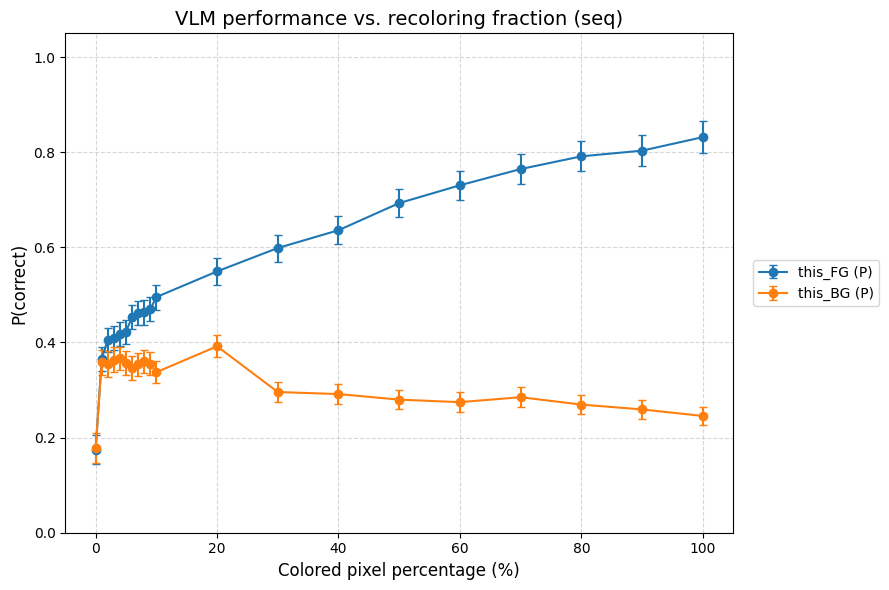

LLaVA-NeXT performance (color prior with image):


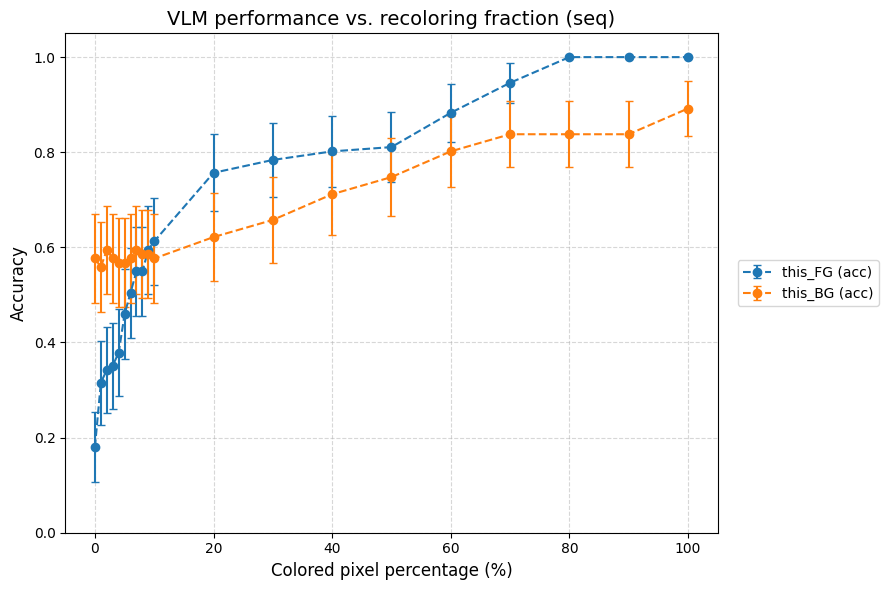

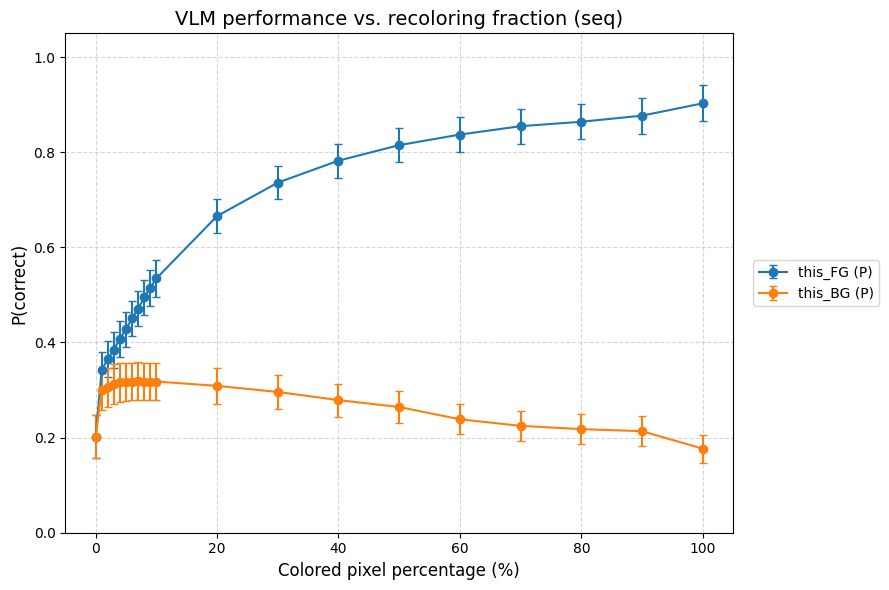

LLaVA-NeXT performance (counterfact coloring):


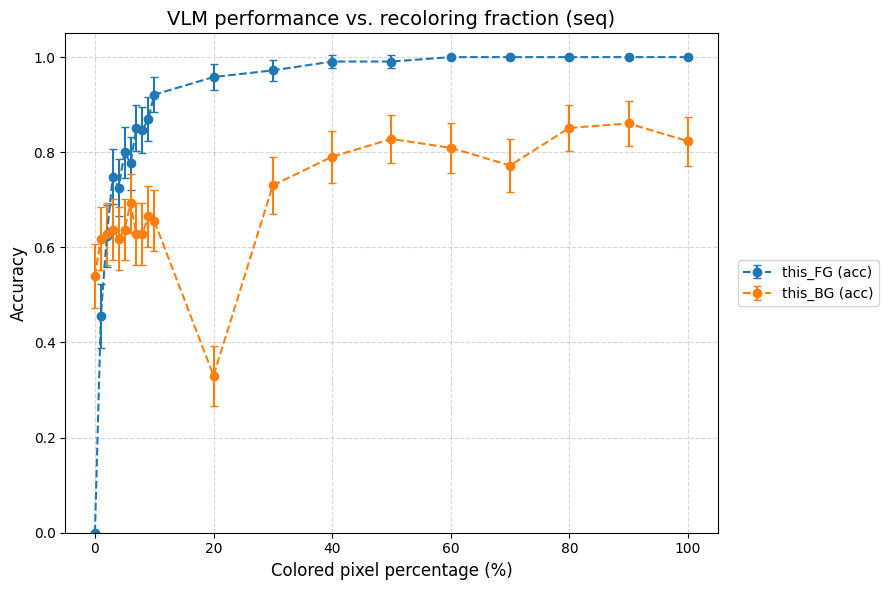

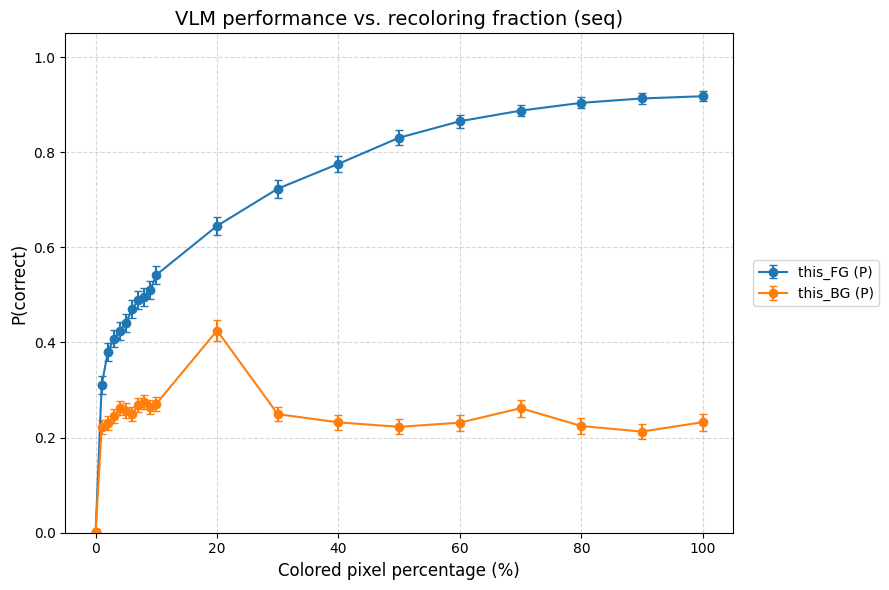

GPT-4o performance (color prior without image):


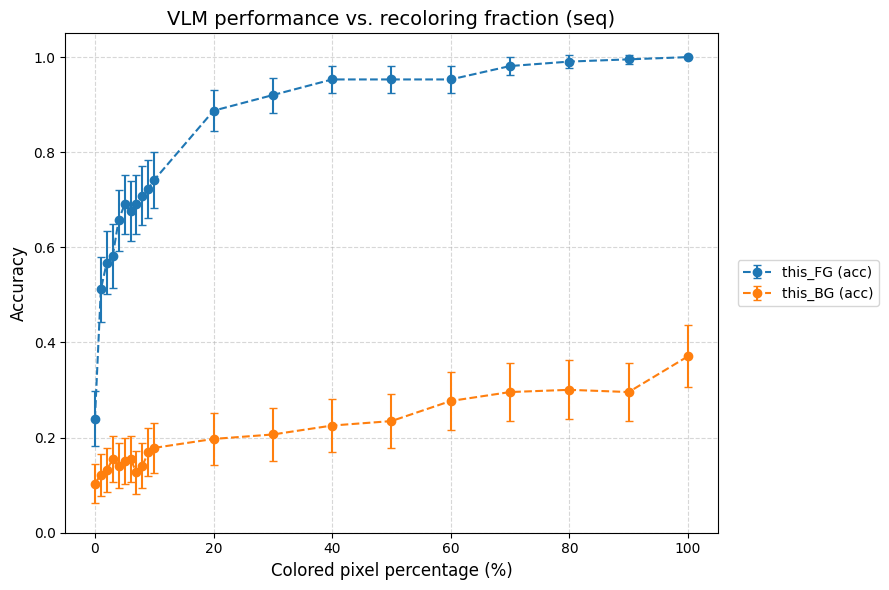

GPT-4o performance (counterfact coloring):


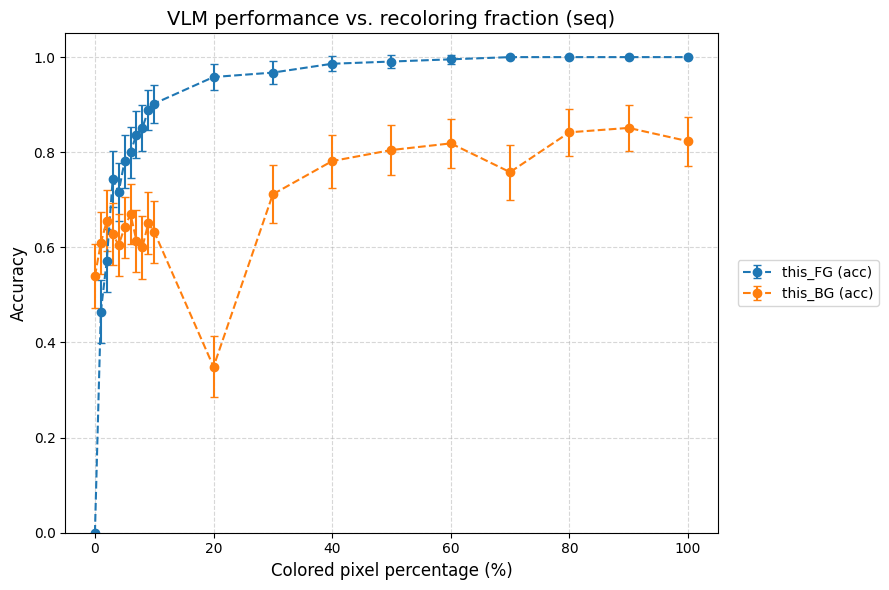

In [34]:
print(f"LLaVA-NeXT performance (color prior without image):")
plot_vlm_performance(llava_dummy, show_accuracy=True, ci=True, show_probability=False)
plot_vlm_performance(llava_dummy, show_accuracy=False, ci=True, show_probability=True)

print(f"LLaVA-NeXT performance (color prior with image):")
plot_vlm_performance(llava_image, show_accuracy=True, ci=True, show_probability=False)
plot_vlm_performance(llava_image, show_accuracy=False, ci=True, show_probability=True)

print(f"LLaVA-NeXT performance (counterfact coloring):")
plot_vlm_performance(llava_counterfact, show_accuracy=True, ci=True, show_probability=False, counterfact=True)
plot_vlm_performance(llava_counterfact, show_accuracy=False, ci=True, show_probability=True)

print(f"GPT-4o performance (color prior without image):")
plot_vlm_performance(gpt_dummy, show_accuracy=True, ci=True, show_probability=False)

print(f"GPT-4o performance (counterfact coloring):")
plot_vlm_performance(gpt_counterfact, show_accuracy=True, ci=True, show_probability=False, counterfact=True)

## 4. Evaluate shape dataset

In [4]:
SHAPES = WORK / "color-concept-entanglement" / "data" / "shapes"
shape_df = pd.read_csv(SHAPES / "shape_dataset.csv")
display(shape_df)

colors = ["red", "brown", "pink", "green", "blue", "yellow", "purple", "orange", "grey", "black"]#
suffix = "shapes"

,object,shape,image_path,cv_mask_path
0,circle_v0,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,circle_v1,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,circle_v2,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,circle_v3,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,circle_v4,circle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
5,triangle_v0,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
6,triangle_v1,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
7,triangle_v2,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
8,triangle_v3,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
9,triangle_v4,triangle,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [ ]:
# Main evaluation of colored shape variants with LLaVA-NeXT only for sequential coloring and 'this' prompt
model_name = "llava-v1.6-mistral-7b-hf"
preds = []

print(f"Running outline variant evaluation of {suffix} with {model_name}...")

for _, row in tqdm(shape_df.iterrows(), total=len(shape_df), desc="Evaluating objects", position=0):
    for target_color in colors:
        image_path = row["image_path"]
        object_name = row["object"]
        
        # Collect all variant image paths for this color
        variant_root = SHAPES / "shape_colored"
        variants = collect_variants_for(image_path, target_color, out_root=variant_root)
        if not variants:
            continue

        # Build a dataframe for all variants of this image
        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants)
        })

        # Run both "most" and "this" question types on all variants
        df_eval = run_vlm_evaluation(
            df=df_variants,
            processor=processor,
            model=model,
            device=device,
            batch_size=1,
            mode="this",
            retrn_probs=True,
            use_gpt=False
        )
        df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this", "prob_correct_this"]]
        preds.append(df_eval)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation of shapes with llava-v1.6-mistral-7b-hf...


Evaluating objects: 100%|██████████| 25/25 [3:36:07<00:00, 518.71s/it]  


Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/evaluation_llava-v1.6-mistral-7b-hf_shapes.csv


,object,image_variant,correct_answer,pred_color_this
0,circle_v0,BG 0% (seq),red,black
1,circle_v0,BG 1% (seq),red,black
2,circle_v0,BG 2% (seq),red,black
3,circle_v0,BG 3% (seq),red,black
4,circle_v0,BG 4% (seq),red,white
5,circle_v0,BG 5% (seq),red,white
6,circle_v0,BG 6% (seq),red,white
7,circle_v0,BG 7% (seq),red,white
8,circle_v0,BG 8% (seq),red,white
9,circle_v0,BG 9% (seq),red,white


In [6]:
# Main evaluation of colored shape variants with GPT-4o only for sequential coloring and 'this' prompt
model_name = "gpt-4o"
preds = []

print(f"Running outline variant evaluation of {suffix} with {model_name}...")

for _, row in tqdm(shape_df.iterrows(), total=len(shape_df), desc="Evaluating objects", position=0):
    for target_color in colors:
        image_path = row["image_path"]
        object_name = row["object"]
        
        # Collect all variant image paths for this color
        variant_root = SHAPES / "shape_colored"
        variants = collect_variants_for(image_path, target_color, out_root=variant_root)
        if not variants:
            continue

        # Build a dataframe for all variants of this image
        df_variants = pd.DataFrame({
            "image_path": [str(p) for p in variants],
            "image_variant": [variant_label(p) for p in variants],
            "object": [object_name] * len(variants),
            "correct_answer": [target_color] * len(variants)
        })

        # Run both "most" and "this" question types on all variants
        df_eval = run_vlm_evaluation(
            df=df_variants,
            processor=processor,
            model=model,
            device=device,
            batch_size=1,
            mode="this",
            use_gpt=True
        )
        df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this"]]
        preds.append(df_eval)

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

pred_df = pd.concat(preds, ignore_index=True)
out_path = DATA / f"evaluation_{model_name}_{suffix}.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation of shapes with gpt-4o...


Evaluating objects: 100%|██████████| 25/25 [2:28:26<00:00, 356.26s/it]  


Saved combined outline evaluation results to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/evaluation_gpt-4o_shapes.csv


,object,image_variant,correct_answer,pred_color_this
0,circle_v0,BG 0% (seq),red,black
1,circle_v0,BG 1% (seq),red,black
2,circle_v0,BG 2% (seq),red,black
3,circle_v0,BG 3% (seq),red,black
4,circle_v0,BG 4% (seq),red,black
5,circle_v0,BG 5% (seq),red,black
6,circle_v0,BG 6% (seq),red,black
7,circle_v0,BG 7% (seq),red,black
8,circle_v0,BG 8% (seq),red,black
9,circle_v0,BG 9% (seq),red,black


In [6]:
gpt_shapes = pd.read_csv(DATA / "evaluation_gpt-4o_shapes.csv")
print(gpt_shapes.shape)
llava_shapes = pd.read_csv(DATA / "evaluation_llava-v1.6-mistral-7b-hf_shapes.csv")
print(llava_shapes.shape)

(10000, 4)
(10000, 4)


In [8]:
print(llava_shapes)

          object  image_variant correct_answer  pred_color_this region  pct  \
0      circle_v0    BG 0% (seq)            red            black     BG    0   
1      circle_v0    BG 1% (seq)            red            black     BG    1   
2      circle_v0    BG 2% (seq)            red            black     BG    2   
3      circle_v0    BG 3% (seq)            red            black     BG    3   
4      circle_v0    BG 4% (seq)            red            white     BG    4   
...          ...            ...            ...              ...    ...  ...   
9995  hexagon_v4   FG 60% (seq)          black  black and white     FG   60   
9996  hexagon_v4   FG 70% (seq)          black  black and white     FG   70   
9997  hexagon_v4   FG 80% (seq)          black            black     FG   80   
9998  hexagon_v4   FG 90% (seq)          black            black     FG   90   
9999  hexagon_v4  FG 100% (seq)          black            black     FG  100   

     mode  
0     seq  
1     seq  
2     seq  
3  

LLaVA-NeXT performance (shapes dataset):


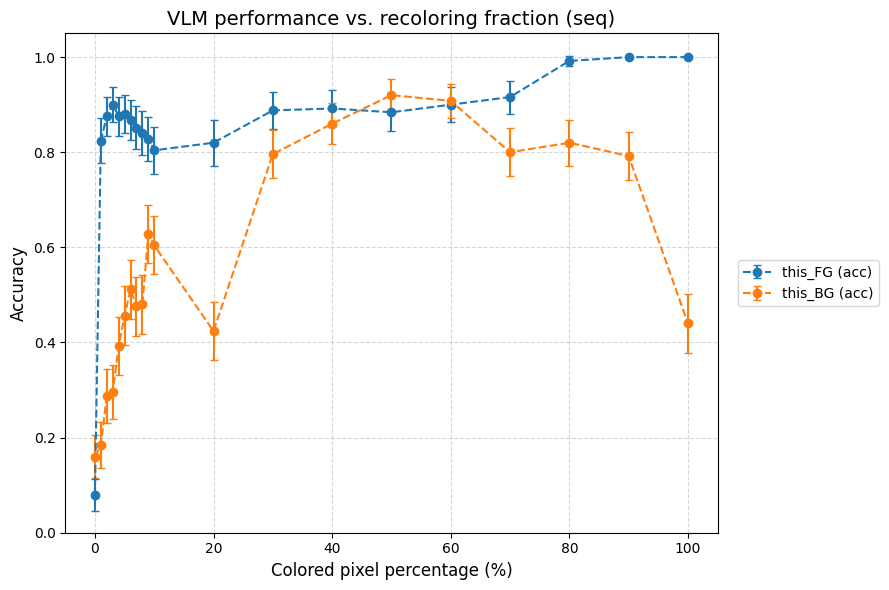

/mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/making_color_images/plot_variants.py:384: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))


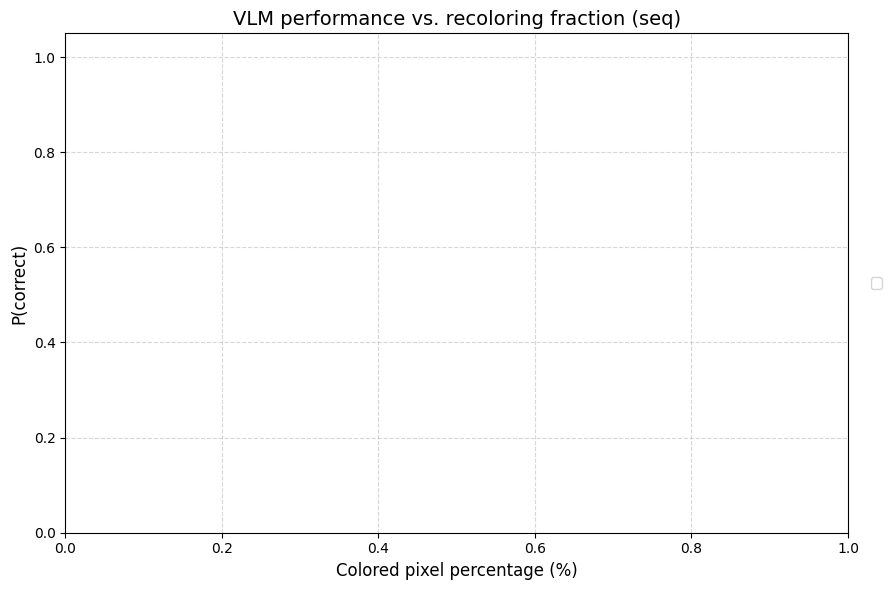

GPT-4o performance (shapes dataset):


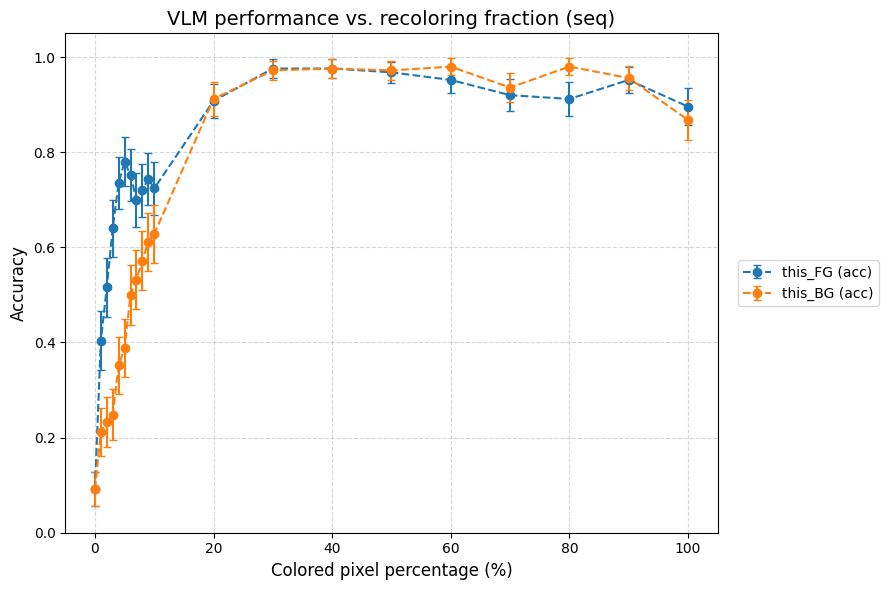

In [7]:
print("LLaVA-NeXT performance (shapes dataset):")
plot_vlm_performance(llava_shapes, show_accuracy=True, ci=True, show_probability=False)
plot_vlm_performance(llava_shapes, show_accuracy=False, ci=True, show_probability=True)

print("GPT-4o performance (shapes dataset):")
plot_vlm_performance(gpt_shapes, show_accuracy=True, ci=True, show_probability=False)